Using device: cuda
Files already downloaded and verified
Epoch 1/3000, Loss: 0.01821
New best model saved!
Epoch 2/3000, Loss: 0.01468
New best model saved!
Epoch 3/3000, Loss: 0.01486
Epoch 4/3000, Loss: 0.01502
Epoch 5/3000, Loss: 0.01417
New best model saved!
Epoch 6/3000, Loss: 0.01395
New best model saved!
Epoch 7/3000, Loss: 0.01422
Epoch 8/3000, Loss: 0.01308
New best model saved!
Epoch 9/3000, Loss: 0.01364
Epoch 10/3000, Loss: 0.01399
Epoch 11/3000, Loss: 0.01433
Epoch 12/3000, Loss: 0.01271
New best model saved!
Epoch 13/3000, Loss: 0.01272
Epoch 14/3000, Loss: 0.01346
Epoch 15/3000, Loss: 0.01304
Epoch 16/3000, Loss: 0.01326
Epoch 17/3000, Loss: 0.01320
Epoch 18/3000, Loss: 0.01365
Epoch 19/3000, Loss: 0.01342
Epoch 20/3000, Loss: 0.01264
New best model saved!
Epoch 21/3000, Loss: 0.01414
Epoch 22/3000, Loss: 0.01320
Epoch 23/3000, Loss: 0.01326
Epoch 24/3000, Loss: 0.01394
Epoch 25/3000, Loss: 0.01276
Epoch 26/3000, Loss: 0.01307
Epoch 27/3000, Loss: 0.01283
Epoch 28/3000, 

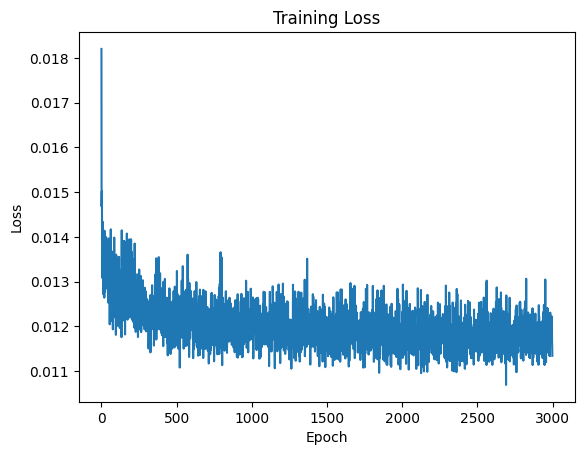

In [11]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, random_split
from PIL import Image
import io
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 設備設置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 下載 CIFAR-10 資料集
dataset = torchvision.datasets.CIFAR10(
    root="cifar10/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

# 資料集拆分
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# JPEG 壓縮函數
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNetDenoiser(nn.Module):
    def __init__(self):
        super(UNetDenoiser, self).__init__()
        self.encoder1 = DoubleConv(3, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(256, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, 3, kernel_size=1)
        
        self.time_embed = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

    def forward(self, x, t):
        t = t.float().view(-1, 1).to(x.device)
        t_embed = self.time_embed(t).view(-1, 512, 1, 1)
        
        x1 = self.encoder1(x)
        x2 = self.encoder2(self.pool(x1))
        x3 = self.encoder3(self.pool(x2))
        
        x = self.bottleneck(x3) + t_embed
        
        x = self.up3(x)
        x3_resized = F.interpolate(x3, size=x.shape[2:], mode="bilinear", align_corners=False)  # 確保大小匹配
        x = self.decoder3(torch.cat([x3_resized, x], dim=1))

        x = self.up2(x)
        x2_resized = F.interpolate(x2, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = self.decoder2(torch.cat([x2_resized, x], dim=1))

        x = self.up1(x)
        x1_resized = F.interpolate(x1, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = self.decoder1(torch.cat([x1_resized, x], dim=1))

        
        return torch.tanh(F.interpolate(self.out_conv(x), size=(32, 32), mode="bilinear", align_corners=False))

net = UNetDenoiser().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100)

n_epochs = 3000
best_loss = float("inf")
loss_history = []
beta_t = torch.linspace(1e-4, 0.02, 100).to(device)
alpha_t_list = 1 - beta_t

for epoch in range(n_epochs):
    net.train()
    epoch_loss = 0
    for x0, _ in train_dataloader:
        x0 = x0.to(device)
        qf = random.randint(1, 100)
        xt = jpeg_compress(x0, qf)
        t = torch.full((x0.shape[0],), 101 - qf, dtype=torch.long, device=device)

        alpha_t = alpha_t_list[t - 1].view(-1, 1, 1, 1)
        alpha_bar_t = torch.exp(torch.cumsum(torch.log(alpha_t), dim=0))

        noise = (xt - torch.sqrt(alpha_bar_t) * x0) / torch.sqrt(1 - alpha_bar_t)
        predicted_noise = net(xt, t.float())
        loss = loss_fn(predicted_noise, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    scheduler.step()
    avg_loss = epoch_loss / len(train_dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.5f}")

    # 儲存最佳 loss 的 model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(net.state_dict(), "best_denoiser.pth")
        print("New best model saved!")

    # 儲存最後一個 epoch 的 model
    if epoch == n_epochs - 1:
        torch.save(net.state_dict(), "last_denoiser.pth")
        print("Final epoch model saved!")

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("loss_curve.png")
print("Loss curve saved as loss_curve.png")

Using device: cuda
Files already downloaded and verified
Image 1: SSIM (Original vs Compressed) = 0.8615, SSIM (Original vs Denoised) = 0.8437, PSNR (Original vs Compressed) = 25.30 dB, PSNR (Original vs Denoised) = 20.03 dB


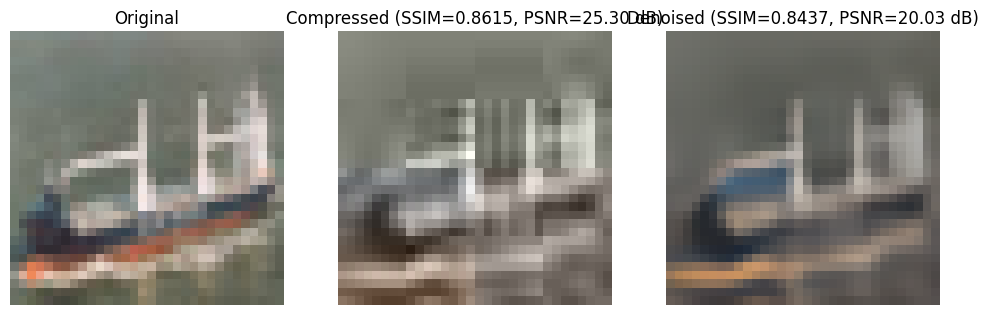

Image 2: SSIM (Original vs Compressed) = 0.9055, SSIM (Original vs Denoised) = 0.8852, PSNR (Original vs Compressed) = 24.07 dB, PSNR (Original vs Denoised) = 20.08 dB


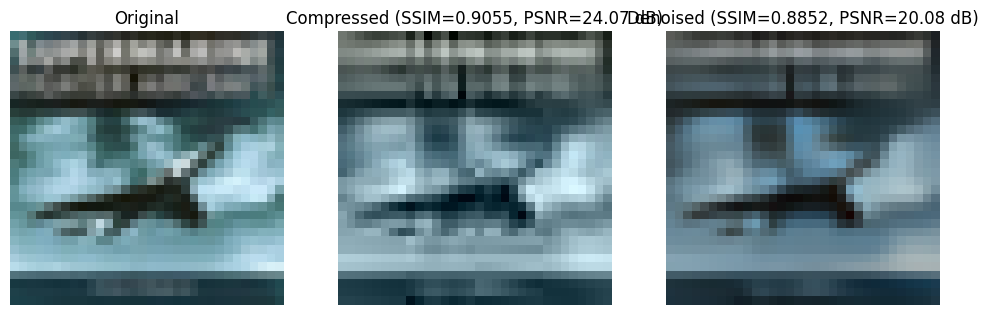

Image 3: SSIM (Original vs Compressed) = 0.8440, SSIM (Original vs Denoised) = 0.8137, PSNR (Original vs Compressed) = 23.30 dB, PSNR (Original vs Denoised) = 19.96 dB


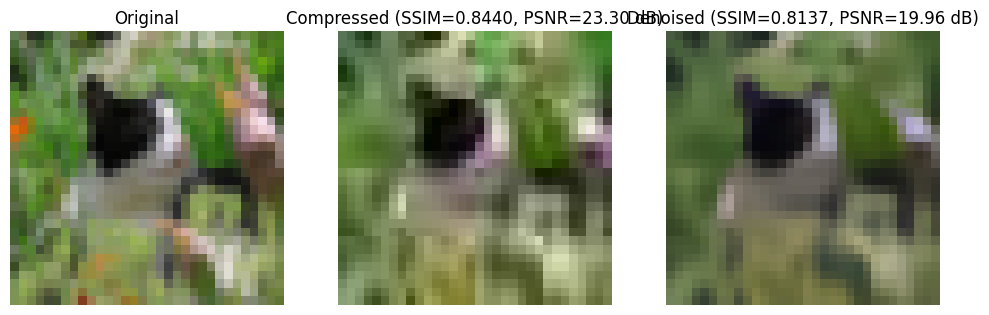

Image 4: SSIM (Original vs Compressed) = 0.9046, SSIM (Original vs Denoised) = 0.8663, PSNR (Original vs Compressed) = 25.09 dB, PSNR (Original vs Denoised) = 19.33 dB


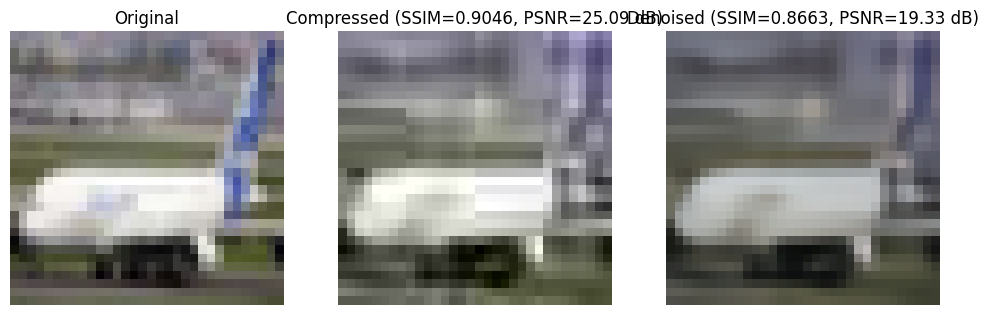

Image 5: SSIM (Original vs Compressed) = 0.9323, SSIM (Original vs Denoised) = 0.8849, PSNR (Original vs Compressed) = 24.82 dB, PSNR (Original vs Denoised) = 19.24 dB


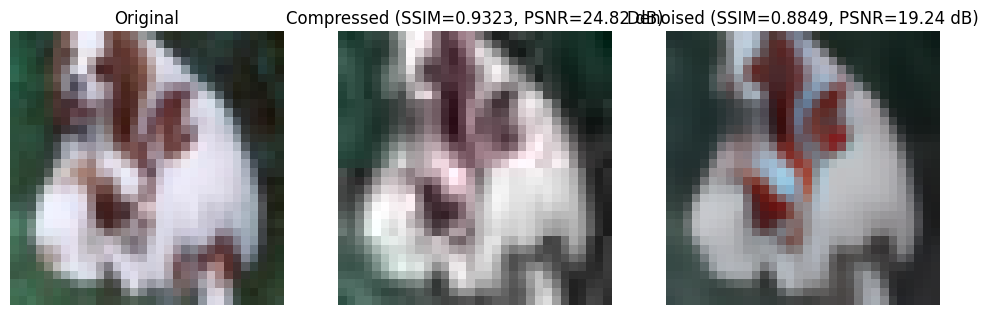

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 6: SSIM (Original vs Compressed) = 0.7098, SSIM (Original vs Denoised) = 0.6380, PSNR (Original vs Compressed) = 22.10 dB, PSNR (Original vs Denoised) = 18.94 dB


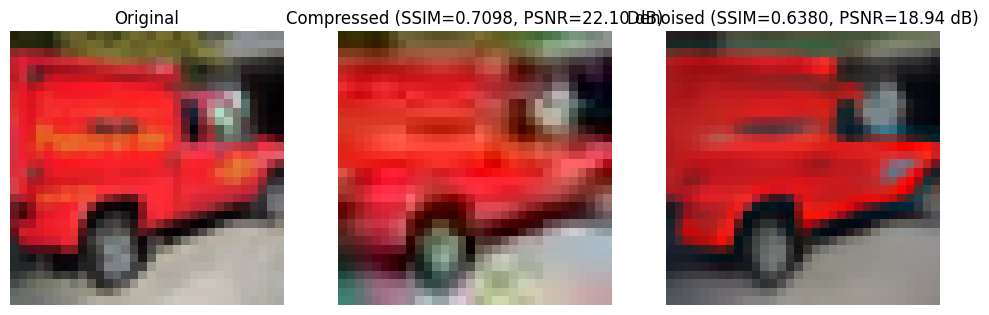

Image 7: SSIM (Original vs Compressed) = 0.9186, SSIM (Original vs Denoised) = 0.9102, PSNR (Original vs Compressed) = 25.47 dB, PSNR (Original vs Denoised) = 20.38 dB


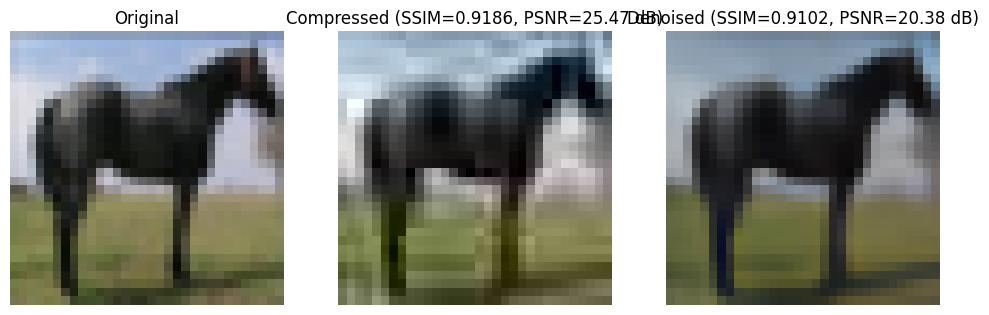

Image 8: SSIM (Original vs Compressed) = 0.7693, SSIM (Original vs Denoised) = 0.7275, PSNR (Original vs Compressed) = 28.65 dB, PSNR (Original vs Denoised) = 24.65 dB


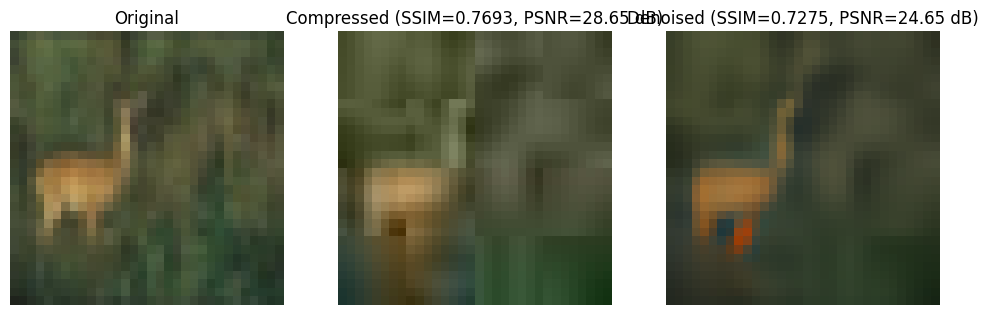

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 9: SSIM (Original vs Compressed) = 0.8796, SSIM (Original vs Denoised) = 0.8963, PSNR (Original vs Compressed) = 27.33 dB, PSNR (Original vs Denoised) = 23.83 dB


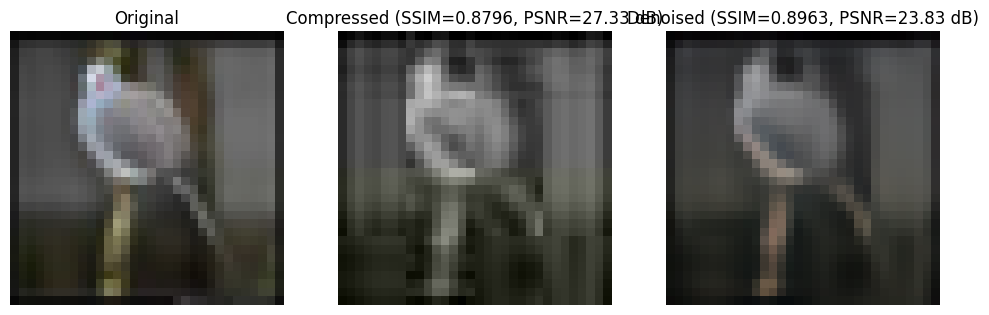

Image 10: SSIM (Original vs Compressed) = 0.8371, SSIM (Original vs Denoised) = 0.7734, PSNR (Original vs Compressed) = 23.87 dB, PSNR (Original vs Denoised) = 18.19 dB


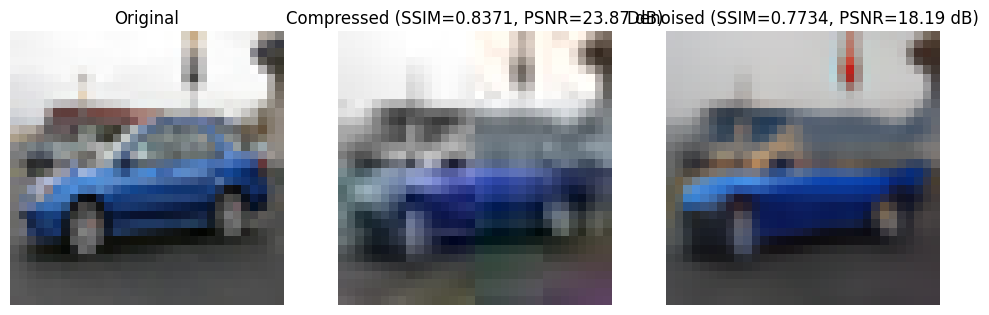

Average SSIM (Original vs Compressed): 0.8562
Average SSIM (Original vs Denoised): 0.8239
Average PSNR (Original vs Compressed): 25.00 dB
Average PSNR (Original vs Denoised): 20.46 dB


In [20]:
import torch
import torchvision
from torch.utils.data import DataLoader
from PIL import Image
import io
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
import torch.nn.functional as F

# 設備設置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 下載 CIFAR-10 測試資料集
dataset = torchvision.datasets.CIFAR10(
    root="cifar10/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# JPEG 壓縮函數
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

# JPEG 壓縮函數
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNetDenoiser(nn.Module):
    def __init__(self):
        super(UNetDenoiser, self).__init__()
        self.encoder1 = DoubleConv(3, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(256, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, 3, kernel_size=1)
        
        self.time_embed = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

    def forward(self, x, t):
        t = t.float().view(-1, 1).to(x.device)
        t_embed = self.time_embed(t).view(-1, 512, 1, 1)
        
        x1 = self.encoder1(x)
        x2 = self.encoder2(self.pool(x1))
        x3 = self.encoder3(self.pool(x2))
        
        x = self.bottleneck(x3) + t_embed
        
        x = self.up3(x)
        x3_resized = F.interpolate(x3, size=x.shape[2:], mode="bilinear", align_corners=False)  # 確保大小匹配
        x = self.decoder3(torch.cat([x3_resized, x], dim=1))

        x = self.up2(x)
        x2_resized = F.interpolate(x2, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = self.decoder2(torch.cat([x2_resized, x], dim=1))

        x = self.up1(x)
        x1_resized = F.interpolate(x1, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = self.decoder1(torch.cat([x1_resized, x], dim=1))

        
        return torch.tanh(F.interpolate(self.out_conv(x), size=(32, 32), mode="bilinear", align_corners=False))


# 加載最佳模型
net = UNetDenoiser().to(device)
net.load_state_dict(torch.load("last_denoiser.pth"))
net.eval()

# 設置 DDPM 相關參數
T = 100
beta_t = torch.linspace(1e-4, 0.02, T).to(device)
alpha_t_list = 1 - beta_t

def ddpm_inference(model, x0, T=80):
    xt = jpeg_compress(x0, quality=20)
    for t in range(T, 0, -1):
        t_tensor = torch.tensor([t], device=device, dtype=torch.float32).view(1, 1)
        predicted_noise = model(xt, t_tensor)
        alpha_t = alpha_t_list[t - 1]
        alpha_bar_t = torch.prod(alpha_t_list[:t])
        xt = (1 / torch.sqrt(alpha_t)) * (xt - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise)
    return xt

# 測試與視覺化
# 計算 PSNR
def psnr(img1, img2, data_range=1.0):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')  # 無限大代表完全相同
    return 10 * torch.log10((data_range ** 2) / mse)

# 測試與視覺化
ssim_compressed_total = 0
ssim_denoised_total = 0
psnr_compressed_total = 0
psnr_denoised_total = 0
num_images = 10  # 測試 10 張圖片

for i, (x0, _) in enumerate(test_dataloader):
    x0 = x0.to(device)
    x_compressed = jpeg_compress(x0, quality=20)
    x_denoised = ddpm_inference(net, x0).detach()
    
    # 計算 SSIM
    ssim_compressed = ssim(x0, x_compressed, data_range=1.0)
    ssim_denoised = ssim(x0, x_denoised, data_range=1.0)

    # 計算 PSNR
    psnr_compressed = psnr(x0, x_compressed, data_range=1.0)
    psnr_denoised = psnr(x0, x_denoised, data_range=1.0)
    
    ssim_compressed_total += ssim_compressed.item()
    ssim_denoised_total += ssim_denoised.item()
    psnr_compressed_total += psnr_compressed.item()
    psnr_denoised_total += psnr_denoised.item()
    
    print(f"Image {i+1}: "
          f"SSIM (Original vs Compressed) = {ssim_compressed:.4f}, "
          f"SSIM (Original vs Denoised) = {ssim_denoised:.4f}, "
          f"PSNR (Original vs Compressed) = {psnr_compressed:.2f} dB, "
          f"PSNR (Original vs Denoised) = {psnr_denoised:.2f} dB")

    # 顯示圖片
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(x0.cpu().squeeze().permute(1, 2, 0))
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    axes[1].imshow(x_compressed.cpu().squeeze().permute(1, 2, 0))
    axes[1].set_title(f"Compressed (SSIM={ssim_compressed:.4f}, PSNR={psnr_compressed:.2f} dB)")
    axes[1].axis("off")
    
    axes[2].imshow(x_denoised.cpu().squeeze().permute(1, 2, 0))
    axes[2].set_title(f"Denoised (SSIM={ssim_denoised:.4f}, PSNR={psnr_denoised:.2f} dB)")
    axes[2].axis("off")
    
    plt.show()
    
    if i >= num_images - 1:
        break

# 計算平均 SSIM 和 PSNR
avg_ssim_compressed = ssim_compressed_total / num_images
avg_ssim_denoised = ssim_denoised_total / num_images
avg_psnr_compressed = psnr_compressed_total / num_images
avg_psnr_denoised = psnr_denoised_total / num_images

print(f"Average SSIM (Original vs Compressed): {avg_ssim_compressed:.4f}")
print(f"Average SSIM (Original vs Denoised): {avg_ssim_denoised:.4f}")
print(f"Average PSNR (Original vs Compressed): {avg_psnr_compressed:.2f} dB")
print(f"Average PSNR (Original vs Denoised): {avg_psnr_denoised:.2f} dB")